# 2020 Alphas

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import datetime

In [2]:
## load stock and market returns
russ_rets = pd.read_csv('inputs/stock_prices.csv')
russ2020 = (russ_rets['Date'] >= '2020-01-01') & (russ_rets['Date'] <= '2020-12-31')

russ_rets = (russ_rets.loc[russ2020]
             .reset_index()
             .drop(columns = ['Unnamed: 0', 'index'])
            )
russ_rets['ret'] = russ_rets['ret']*100
russ_rets['Date'] = pd.to_datetime(russ_rets['Date'])

## load market returns
ff = pdr.get_data_famafrench('F-F_Research_Data_5_Factors_2x3_daily',start='1-1-2020',end='12-31-2020')[0] # the [0] is because the imported obect is a dictionary, and key=0 is the dataframe
ff = ff.reset_index().rename(columns={"Mkt-RF":"mkt_excess"})

In [3]:
## merge stock returns and market returns
russ_ready = pd.merge(left = ff, right = russ_rets, on = 'Date', how = 'inner',
                     indicator = True, validate = 'one_to_many')

In [4]:
russ_ready

,Date,mkt_excess,SMB,HML,RMW,CMA,RF,Firm,Adj Close,ret,_merge
0,2020-01-02,0.86,-0.95,-0.36,0.20,-0.22,0.006,AA,21.420000,-0.418411,both
1,2020-01-02,0.86,-0.95,-0.36,0.20,-0.22,0.006,AAIC,5.540000,-0.538603,both
2,2020-01-02,0.86,-0.95,-0.36,0.20,-0.22,0.006,AAOI,12.500000,5.218854,both
3,2020-01-02,0.86,-0.95,-0.36,0.20,-0.22,0.006,AAON,49.573929,0.971464,both
4,2020-01-02,0.86,-0.95,-0.36,0.20,-0.22,0.006,AAT,43.221947,-2.004347,both
...,...,...,...,...,...,...,...,...,...,...,...
493083,2020-12-31,0.39,-0.69,0.45,0.56,-0.20,0.000,ZIXI,8.630000,1.053866,both
493084,2020-12-31,0.39,-0.69,0.45,0.56,-0.20,0.000,ZNTL,51.939999,-6.750453,both
493085,2020-12-31,0.39,-0.69,0.45,0.56,-0.20,0.000,ZUMZ,36.779999,0.436919,both
493086,2020-12-31,0.39,-0.69,0.45,0.56,-0.20,0.000,ZUO,13.930000,-1.275686,both


In [5]:
import statsmodels.api as sm

def reg_in_groupby(df,formula="ret_excess ~ mkt_excess + SMB + HML"):
    '''
    Want to run regressions after groupby?
    
    This will do it! 
    
    Note: This defaults to a FF3 model assuming specific variable names. If you
    want to run any other regression, just specify your model.
    
    Usage: 
        df.groupby(<whatever>).apply(reg_in_groupby)
        df.groupby(<whatever>).apply(reg_in_groupby,formula=<whatever>)
    '''
    return pd.Series(sm.formula.ols(formula,data = df).fit().params)

In [6]:
## calculate factor loadings per year for each firm

russ_factors = (russ_ready
    .assign(year = russ_ready.Date.dt.year,
           ret_excess = russ_ready.ret - russ_ready.RF)
    .groupby(['Firm','year']).apply(reg_in_groupby)
    .rename(columns={'Intercept':'alpha','mkt_excess':'beta'})
    .reset_index()
)

russ_factors

,Firm,year,alpha,beta,SMB,HML
0,AA,2020,0.149983,1.219342,0.746321,1.057397
1,AAIC,2020,0.007268,1.316431,1.928043,0.766418
2,AAN,2020,-0.805408,-0.424323,0.958223,2.331416
3,AAOI,2020,-0.239881,1.112773,1.362974,-0.703320
4,AAON,2020,0.126174,0.756660,0.109598,0.296541
...,...,...,...,...,...,...
2013,ZIXI,2020,0.031191,1.294936,1.433366,-0.346849
2014,ZNTL,2020,0.137042,0.888832,1.209811,-0.914755
2015,ZUMZ,2020,0.094991,0.647348,1.345986,0.603539
2016,ZUO,2020,-0.173194,1.048102,0.544978,-0.945533


In [7]:
## set up date column to prepare for merge
russ_dates = russ_ready.groupby(['Firm','Date'])['mkt_excess','SMB','HML','ret'].mean()
russ_dates = russ_dates.reset_index()
russ_dates['Date'] = russ_dates['Date'].dt.strftime('%Y-%m-%d')

russ_dates

<ipython-input-7-5b79e2f00e8f>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  russ_dates = russ_ready.groupby(['Firm','Date'])['mkt_excess','SMB','HML','ret'].mean()


,Firm,Date,mkt_excess,SMB,HML,ret
0,AA,2020-01-02,0.86,-0.95,-0.36,-0.418411
1,AA,2020-01-03,-0.67,0.28,0.02,0.373482
2,AA,2020-01-06,0.36,-0.22,-0.56,-2.325581
3,AA,2020-01-07,-0.19,-0.04,-0.21,1.523808
4,AA,2020-01-08,0.47,-0.17,-0.63,-4.033774
...,...,...,...,...,...,...
493083,ZYXI,2020-12-24,0.21,-0.43,-0.17,-1.013761
493084,ZYXI,2020-12-28,0.46,-0.65,0.32,-0.877834
493085,ZYXI,2020-12-29,-0.40,-1.42,0.24,-1.697421
493086,ZYXI,2020-12-30,0.27,1.03,0.04,5.555561


In [8]:
## merge DF with dates into DF with factors
factors_dates = pd.merge(left = russ_factors, right = russ_dates, how = 'inner',
                on = 'Firm', validate = 'one_to_many')

factors_dates = (factors_dates
            .rename(columns={'beta':'beta_i','SMB_x':'SMB_i',
                     'HML_x':'HML_i', 'mkt_excess':'mktret_t',
                     'SMB_y':'SMBret_t','HML_y':'HMLret_t'})
            .drop(columns = ['alpha','year']))

factors_dates

,Firm,beta_i,SMB_i,HML_i,Date,mktret_t,SMBret_t,HMLret_t,ret
0,AA,1.219342,0.746321,1.057397,2020-01-02,0.86,-0.95,-0.36,-0.418411
1,AA,1.219342,0.746321,1.057397,2020-01-03,-0.67,0.28,0.02,0.373482
2,AA,1.219342,0.746321,1.057397,2020-01-06,0.36,-0.22,-0.56,-2.325581
3,AA,1.219342,0.746321,1.057397,2020-01-07,-0.19,-0.04,-0.21,1.523808
4,AA,1.219342,0.746321,1.057397,2020-01-08,0.47,-0.17,-0.63,-4.033774
...,...,...,...,...,...,...,...,...,...
493083,ZYXI,1.050255,1.211245,-0.805182,2020-12-24,0.21,-0.43,-0.17,-1.013761
493084,ZYXI,1.050255,1.211245,-0.805182,2020-12-28,0.46,-0.65,0.32,-0.877834
493085,ZYXI,1.050255,1.211245,-0.805182,2020-12-29,-0.40,-1.42,0.24,-1.697421
493086,ZYXI,1.050255,1.211245,-0.805182,2020-12-30,0.27,1.03,0.04,5.555561


In [9]:
## create expected return and daily alpha vars
alphas_2020 = factors_dates.assign(exp_ret =
                                   factors_dates.beta_i*factors_dates.mktret_t
                                   + factors_dates.SMB_i*factors_dates.SMBret_t
                                   + factors_dates.HML_i+factors_dates.HMLret_t)
alphas_2020 = (alphas_2020
               .assign(daily_alpha = alphas_2020.ret - alphas_2020.exp_ret)
               .set_index(['Firm','Date'])
               .reset_index()
              )

alphas_2020

,Firm,Date,beta_i,SMB_i,HML_i,mktret_t,SMBret_t,HMLret_t,ret,exp_ret,daily_alpha
0,AA,2020-01-02,1.219342,0.746321,1.057397,0.86,-0.95,-0.36,-0.418411,1.037026,-1.455437
1,AA,2020-01-03,1.219342,0.746321,1.057397,-0.67,0.28,0.02,0.373482,0.469408,-0.095926
2,AA,2020-01-06,1.219342,0.746321,1.057397,0.36,-0.22,-0.56,-2.325581,0.772169,-3.097751
3,AA,2020-01-07,1.219342,0.746321,1.057397,-0.19,-0.04,-0.21,1.523808,0.585869,0.937939
4,AA,2020-01-08,1.219342,0.746321,1.057397,0.47,-0.17,-0.63,-4.033774,0.873613,-4.907387
...,...,...,...,...,...,...,...,...,...,...,...
493083,ZYXI,2020-12-24,1.050255,1.211245,-0.805182,0.21,-0.43,-0.17,-1.013761,-1.275464,0.261704
493084,ZYXI,2020-12-28,1.050255,1.211245,-0.805182,0.46,-0.65,0.32,-0.877834,-0.789374,-0.088460
493085,ZYXI,2020-12-29,1.050255,1.211245,-0.805182,-0.40,-1.42,0.24,-1.697421,-2.705252,1.007832
493086,ZYXI,2020-12-30,1.050255,1.211245,-0.805182,0.27,1.03,0.04,5.555561,0.765969,4.789592


In [10]:
# alphas_2020.to_csv('inputs/alphas_2020.csv')

<br><br><br><br><br><br><br><br>

# Rally (Jan 2021-Feb 2021) Alphas

In [11]:
## load stock and market returns
russ_rets2 = pd.read_csv('inputs/stock_prices.csv')
russ2021 = (russ_rets2['Date'] >= '2021-01-01') & (russ_rets2['Date'] <= '2021-02-28')

russ_rets2 = (russ_rets2.loc[russ2021]
             .reset_index()
             .drop(columns = ['Unnamed: 0', 'index'])
            )
russ_rets2['ret'] = russ_rets2['ret']*100
russ_rets2['Date'] = pd.to_datetime(russ_rets2['Date'])

## load market returns
ff = pdr.get_data_famafrench('F-F_Research_Data_5_Factors_2x3_daily',start='1-1-2021',end='2-28-2021')[0] # the [0] is because the imported obect is a dictionary, and key=0 is the dataframe
ff = ff.reset_index().rename(columns={"Mkt-RF":"mkt_excess"})

In [12]:
## merge stock returns and market returns
russ_ready2 = pd.merge(left = ff, right = russ_rets2, on = 'Date', how = 'inner',
                     indicator = True, validate = 'one_to_many')

In [13]:
## calculate factor loadings per year for each firm

russ_factors2 = (russ_ready2
    .assign(year = russ_ready2.Date.dt.year,
           ret_excess = russ_ready2.ret - russ_ready2.RF)
    .groupby(['Firm','year']).apply(reg_in_groupby)
    .rename(columns={'Intercept':'alpha','mkt_excess':'beta'})
    .reset_index()
)

In [14]:
## set up date column to prepare for merge
russ_dates2 = russ_ready2.groupby(['Firm','Date'])['mkt_excess','SMB','HML','ret'].mean()
russ_dates2 = russ_ready2.reset_index()
russ_dates2['Date'] = russ_dates2['Date'].dt.strftime('%Y-%m-%d')

<ipython-input-14-6a295564c87d>:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  russ_dates2 = russ_ready2.groupby(['Firm','Date'])['mkt_excess','SMB','HML','ret'].mean()


In [15]:
## merge DF with dates into DF with factors
factors_dates2 = pd.merge(left = russ_factors2, right = russ_dates2, how = 'inner',
                on = 'Firm', validate = 'one_to_many')

factors_dates2 = (factors_dates2
            .rename(columns={'beta':'beta_i','SMB_x':'SMB_i',
                     'HML_x':'HML_i', 'mkt_excess':'mktret_t',
                     'SMB_y':'SMBret_t','HML_y':'HMLret_t'})
            .drop(columns = ['alpha','year']))

In [16]:
## create expected return and daily alpha vars

alphas_2021 = factors_dates2.assign(exp_ret =
                                   factors_dates2.beta_i*factors_dates2.mktret_t
                                   + factors_dates2.SMB_i*factors_dates2.SMBret_t
                                   + factors_dates2.HML_i+factors_dates2.HMLret_t)
alphas_2021 = (alphas_2021
               .assign(daily_alpha = alphas_2021.ret - alphas_2021.exp_ret)
               .set_index(['Firm','Date'])
               .reset_index()
              )

In [17]:
alphas_2021

,Firm,Date,beta_i,SMB_i,HML_i,index,mktret_t,SMBret_t,HMLret_t,RMW,CMA,RF,Adj Close,ret,_merge,exp_ret,daily_alpha
0,AA,2021-01-04,2.029919,1.096107,1.875281,0,-1.41,0.19,0.53,-0.63,0.06,0.0,23.250000,0.867682,both,-0.248645,1.116327
1,AA,2021-01-05,2.029919,1.096107,1.875281,2012,0.86,1.31,0.51,0.39,0.56,0.0,23.670000,1.806452,both,5.566913,-3.760461
2,AA,2021-01-06,2.029919,1.096107,1.875281,4024,0.79,3.13,3.89,0.10,0.60,0.0,25.209999,6.506122,both,10.799734,-4.293612
3,AA,2021-01-07,2.029919,1.096107,1.875281,6036,1.76,0.01,-0.85,-1.48,-0.26,0.0,25.230000,0.079335,both,4.608900,-4.529565
4,AA,2021-01-08,2.029919,1.096107,1.875281,8049,0.51,-0.96,-1.35,-0.32,-0.34,0.0,24.990000,-0.951248,both,0.508277,-1.459525
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76787,ZYXI,2021-02-22,0.547788,2.472041,0.364364,68661,-1.13,0.68,3.14,1.66,0.90,0.0,19.020000,6.435364,both,4.566351,1.869013
76788,ZYXI,2021-02-23,0.547788,2.472041,0.364364,70693,-0.15,-1.05,0.90,1.08,-0.19,0.0,18.070000,-4.994746,both,-1.413447,-3.581299
76789,ZYXI,2021-02-24,0.547788,2.472041,0.364364,72726,1.15,1.48,1.34,-0.29,0.32,0.0,18.420000,1.936914,both,5.992941,-4.056027
76790,ZYXI,2021-02-25,0.547788,2.472041,0.364364,74759,-2.74,-0.90,0.87,1.00,0.47,0.0,17.420000,-5.428882,both,-2.491412,-2.937469


In [18]:
# alphas_2021.to_csv('inputs/alphas_2021.csv')

<br><br><br><br><br>

## Plotting Alphas

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

In [20]:
alph_2021 = pd.read_csv('inputs/alphas_2021.csv')
short = pd.read_csv('inputs/short_data.csv')

a = alph_2021.groupby('Firm')['daily_alpha'].mean().to_frame()
short_avg = short.groupby('ticker')['short_int'].mean().to_frame()
short_c = short_avg.reset_index().rename(columns={'ticker':'Firm'})
alpha_short = pd.merge(a, short_c, on='Firm', how='left', validate = 'many_to_one')

In [21]:
conditions  = [ alpha_short['short_int'] >= .4, (alpha_short['short_int'] < .4) & (alpha_short['short_int'] > .3), alpha_short['short_int'] <= .3 ]
choices     = [ "high", 'medium', 'low' ]
    
alpha_short["short_level"] = np.select(conditions, choices, default=np.nan)
alpha_short = alpha_short.drop(alpha_short[(alpha_short['short_level'] == 'nan')].index)
alpha_short.groupby('short_level')['daily_alpha'].mean()

short_level
high      12.063502
low       -0.089013
medium    -0.164844
Name: daily_alpha, dtype: float64

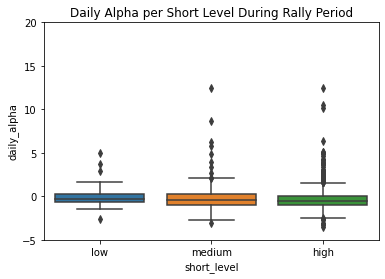

In [22]:
ax = sns.boxplot(data=alpha_short,x='short_level',y="daily_alpha", order =['low','medium','high'])

ax.set_ylim(-5,20)
ax.set(title='Daily Alpha per Short Level During Rally Period')

# plt.savefig('report_graphs_tables/Daily_Alpha.png')
plt.show()

<br><br><br><br><br>

# Calculating Alpha Correlations

## 2020 Alphas

In [23]:
## isolate necessary variables
alphas_2020 = alphas_2020[['Firm','Date','daily_alpha']]

In [24]:
## create correlation matrix
corr_2020 = alphas_2020.set_index(['Firm','Date']).unstack(level = 0).corr()
corr_2020 = corr_2020.stack().reset_index(level = 2)

In [25]:
## reformatting
alphas_2020_corr = corr_2020.reset_index(level = 0).drop(['level_0'], axis = 1)
alphas_2020_corr = (alphas_2020_corr
    .rename(columns = {'Firm':'Firm 2', 'daily_alpha':'Pre-Rally Alpha Corr.'})
    .reset_index()
    .rename(columns = {'Firm':'Firm 1'})
    .round(3)
                   )

alphas_2020_corr

,Firm 1,Firm 2,Pre-Rally Alpha Corr.
0,AA,AA,1.000
1,AA,AAIC,-0.148
2,AA,AAN,-0.102
3,AA,AAOI,0.010
4,AA,AAON,-0.207
...,...,...,...
4072147,ZYXI,ZIXI,0.252
4072148,ZYXI,ZNTL,0.315
4072149,ZYXI,ZUMZ,0.065
4072150,ZYXI,ZUO,0.297


## Rally Alphas

In [26]:
## isolate necessary variables
alphas_2021 = alphas_2021[['Firm','Date','daily_alpha']]

In [27]:
## create correlation matrix
corr_2021 = alphas_2021.set_index(['Firm','Date']).unstack(level = 0).corr()
corr_2021 = corr_2021.stack().reset_index(level = 2)

In [28]:
## reformatting
alphas_2021_corr = corr_2021.reset_index(level = 0).drop(['level_0'], axis = 1)
alphas_2021_corr = (alphas_2021_corr
    .rename(columns = {'Firm':'Firm 2', 'daily_alpha':'Rally Alpha Corr.'})
    .reset_index()
    .rename(columns = {'Firm':'Firm 1'})
    .round(3)
                   )
    
alphas_2021_corr

,Firm 1,Firm 2,Rally Alpha Corr.
0,AA,AA,1.000
1,AA,AAIC,-0.155
2,AA,AAN,0.091
3,AA,AAOI,0.032
4,AA,AAON,-0.431
...,...,...,...
4133084,ZYXI,ZIXI,0.501
4133085,ZYXI,ZNTL,0.075
4133086,ZYXI,ZUMZ,-0.120
4133087,ZYXI,ZUO,0.215


In [29]:
## merge pre and post-rally alphas
alphas = pd.merge(left = alphas_2020_corr, right = alphas_2021_corr, how = 'inner',
         on = ['Firm 1', 'Firm 2'], validate = '1:1')

## drop where Firm 1 and Firm 2 are the same, reformat
alphas.drop(alphas[alphas['Firm 1'] == alphas['Firm 2']].index, inplace = True)
alphas = alphas.reset_index().drop(columns = ['index'])

## drop duplicates
alphas = alphas.loc[pd.DataFrame(np.sort(alphas[['Firm 1','Firm 2']],1),index=alphas.index).drop_duplicates(keep='first').index]
alphas = alphas.reset_index().drop(columns = ['index'])

alphas

,Firm 1,Firm 2,Pre-Rally Alpha Corr.,Rally Alpha Corr.
0,AA,AAIC,-0.148,-0.155
1,AA,AAN,-0.102,0.091
2,AA,AAOI,0.010,0.032
3,AA,AAON,-0.207,-0.431
4,AA,AAT,-0.049,0.113
...,...,...,...,...
2027048,ZNTL,ZUO,0.403,0.026
2027049,ZNTL,ZYXI,0.315,0.075
2027050,ZUMZ,ZUO,0.211,0.015
2027051,ZUMZ,ZYXI,0.065,-0.120


In [30]:
# alphas.to_csv('inputs/alphas_corr.csv.gz', index = False, compression = 'gzip')